# EarthCam Data Science Candidate Assignment - Data Analysis
### Predicting Weather Data in Joliet, IL in 2024

We are given a historical dataset of weather conditions on which we'll train a ML model to base our temp. predictions.  
Let's begin by importing necessary libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [3]:
weather_data = pd.read_csv("cleaned_weather_data_1.csv")
weather_data.sample()

ObservationDateTime  Temperature(F)  Dewpoint(F)  FeelsLike(F)  Pressure(mb)  PrecipDay(in)  PrecipYr(in)  WindSpeed(mph) WindDirection  RelativeHumidity  Visibility(mi)    Conditions  SunRise(HH)  SunSet(HH)
863  2018-12-01 05:55:00-06:00            37.0           36            28       1007.45            0.0         12.51            15.0         North             0.932             5.0  Overcast Sky            6          16

Ideas:
- visualize temperature trends over time
- show correlation between variables
- check for outliers

### Temp Trends

Let's start by plotting all the temperature values over the dataset time period


In [4]:

fig = px.scatter(weather_data, x='ObservationDateTime', y='Temperature(F)',
                 title="Temperatures in (Joliet, IL)\nMay 2018 - May 2023)")

fig.update_traces(marker={ "size" : 2,
                           "color": "magenta",
                           "opacity": 0.5,
                           "line": {"width": 1, "color": "red"},
                           "symbol": "square"})

fig.show()

As expected, we see seasonality in the temperature data, where the time of year affects the temperature.

Let's visualize the distribution of temperature grouped by month.

In [5]:
weather_data_datetime_index = weather_data.copy(deep=True)

Text(0.5, 1.0, 'Temperature Distributions by Month (Joliet, IL)\nMay 2018 - May 2023')

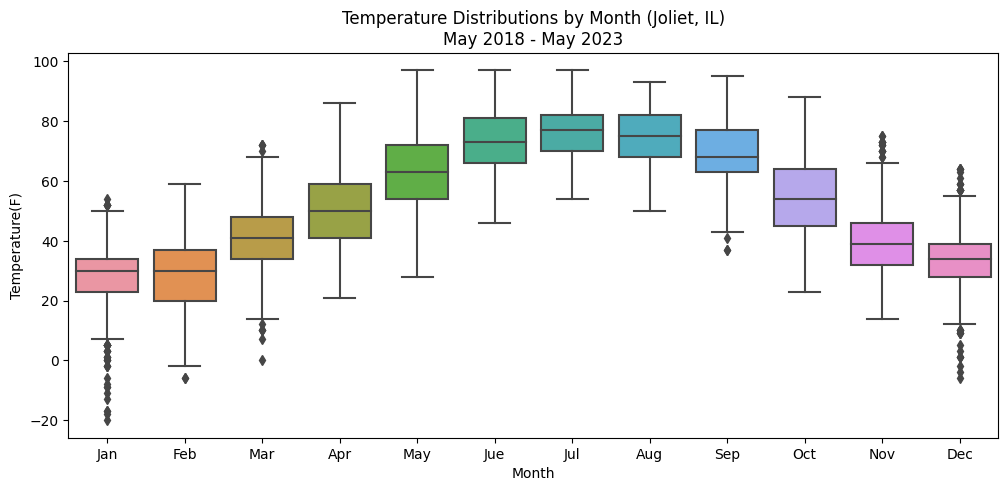

In [6]:
### I forgot to change the contents of the "ObservationDateTime" column to DateTime objects. We list utc=True in for compatibility issues with plotly express

weather_data_datetime_index.set_index("ObservationDateTime", inplace=True)
weather_data_datetime_index.index = pd.to_datetime(weather_data_datetime_index.index, utc=True)

fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x = weather_data_datetime_index.index.month,
                y = weather_data_datetime_index['Temperature(F)'], 
                ax = ax)

plt.xlabel('Month')

plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11],
            labels=["Jan","Feb","Mar","Apr","May","Jue","Jul","Aug","Sep","Oct","Nov","Dec"])

plt.title("Temperature Distributions by Month (Joliet, IL)\nMay 2018 - May 2023")

Let's encode the month of each temperature recording into the dataset. We'll extract the month from each datetime object, add it to the dataset into a new "Months" columns, and then finally one hot encode the month values.

In [7]:
len(weather_data) == len(weather_data_datetime_index)

True

In [8]:
months = []

for i in range(len(weather_data_datetime_index)):
    date_time = weather_data_datetime_index.index[i]
    month = date_time.month
    months.append(month)

months_df = pd.DataFrame(months)
months_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7324 entries, 0 to 7323
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       7324 non-null   int64
dtypes: int64(1)
memory usage: 57.3 KB


In [9]:
weather_data_datetime_index.insert(0, "Month", months)

The boxplot tells us that temperature outliers are more common in early/late stages of the year. Let's examine if we can find out what the cause of these outliers may be. In this case, outliers are temperatures roughly less than 5 degrees F or greater than around 60 degrees F

In [10]:
winter_months = [1,2,3,11,12]

In [11]:
winter_data = weather_data_datetime_index[weather_data_datetime_index.index.month.isin(winter_months)]

In [12]:
### let's check out low outlier temps
winter_too_low = winter_data[winter_data["Temperature(F)"] <= 5]

In [13]:
winter_too_low.sample(10)

Month  Temperature(F)  Dewpoint(F)  FeelsLike(F)  Pressure(mb)  PrecipDay(in)  PrecipYr(in)  WindSpeed(mph) WindDirection  RelativeHumidity  Visibility(mi)    Conditions  SunRise(HH)  SunSet(HH)
ObservationDateTime                                                                                                                                                                                                          
2021-02-07 05:55:00+00:00      2             3.0           -4            -9       1021.00           0.00          0.25             6.9          West             0.715            10.0   Clear Skies            6          17
2021-02-15 11:55:00+00:00      2             1.0           -4           -15       1030.48           0.00          0.25            10.4         North             0.777             1.0    Broken Sky            6          17
2020-01-19 11:55:00+00:00      1             3.0           -4           -15       1023.03           0.00          0.11            13.8          West             0.715            10.0     Scattered            7          16
2021-02-03 11:55:00+00:00      2             3.0            0             3       1022.69           0.00          0.25             0.0         North             0.847             7.0   Clear Skies            7          17
2019-01-25 05:55:00+00:00      1             3.0           -4           -16       1021.34           0.03          0.20            15.0          West             0.715            10.0   Clear Skies            7          16
2021-02-06 11:55:00+00:00      2             5.0            0            -5       1017.27           0.00          0.25             4.6          West             0.781            10.0   Clear Skies            6          17
2022-01-26 05:55:00+00:00      1             0.0          -11             0       1031.50           0.00          0.51             3.4         North             0.596            10.0   Clear Skies            7          17
2022-12-23 04:35:00+00:00     12            -4.0          -11           -25       1012.87           0.00         10.71            15.0          West             0.706             4.0  Overcast Sky            7          16
2022-12-24 05:15:00+00:00     12             1.0           -8           -18       1013.89           0.00         10.71            15.0          West             0.654            10.0  Overcast Sky            7          16
2019-01-29 23:55:00+00:00      1             1.0           -8           -18       1017.27           0.03          0.20            13.8          West             0.654            10.0   Clear Skies            7          17

Wind direction seems to stand out here, as Northern winds would defintely seem to have an outside impact on temperatures

In [14]:
winter_too_low["WindDirection"].value_counts()

WindDirection
West     31
North    30
South     2
Name: count, dtype: int64

So, in aggregate, low outlier temps in the winter correspond to Northern and Western winds. Let's take a look at a map and see if this makes sense

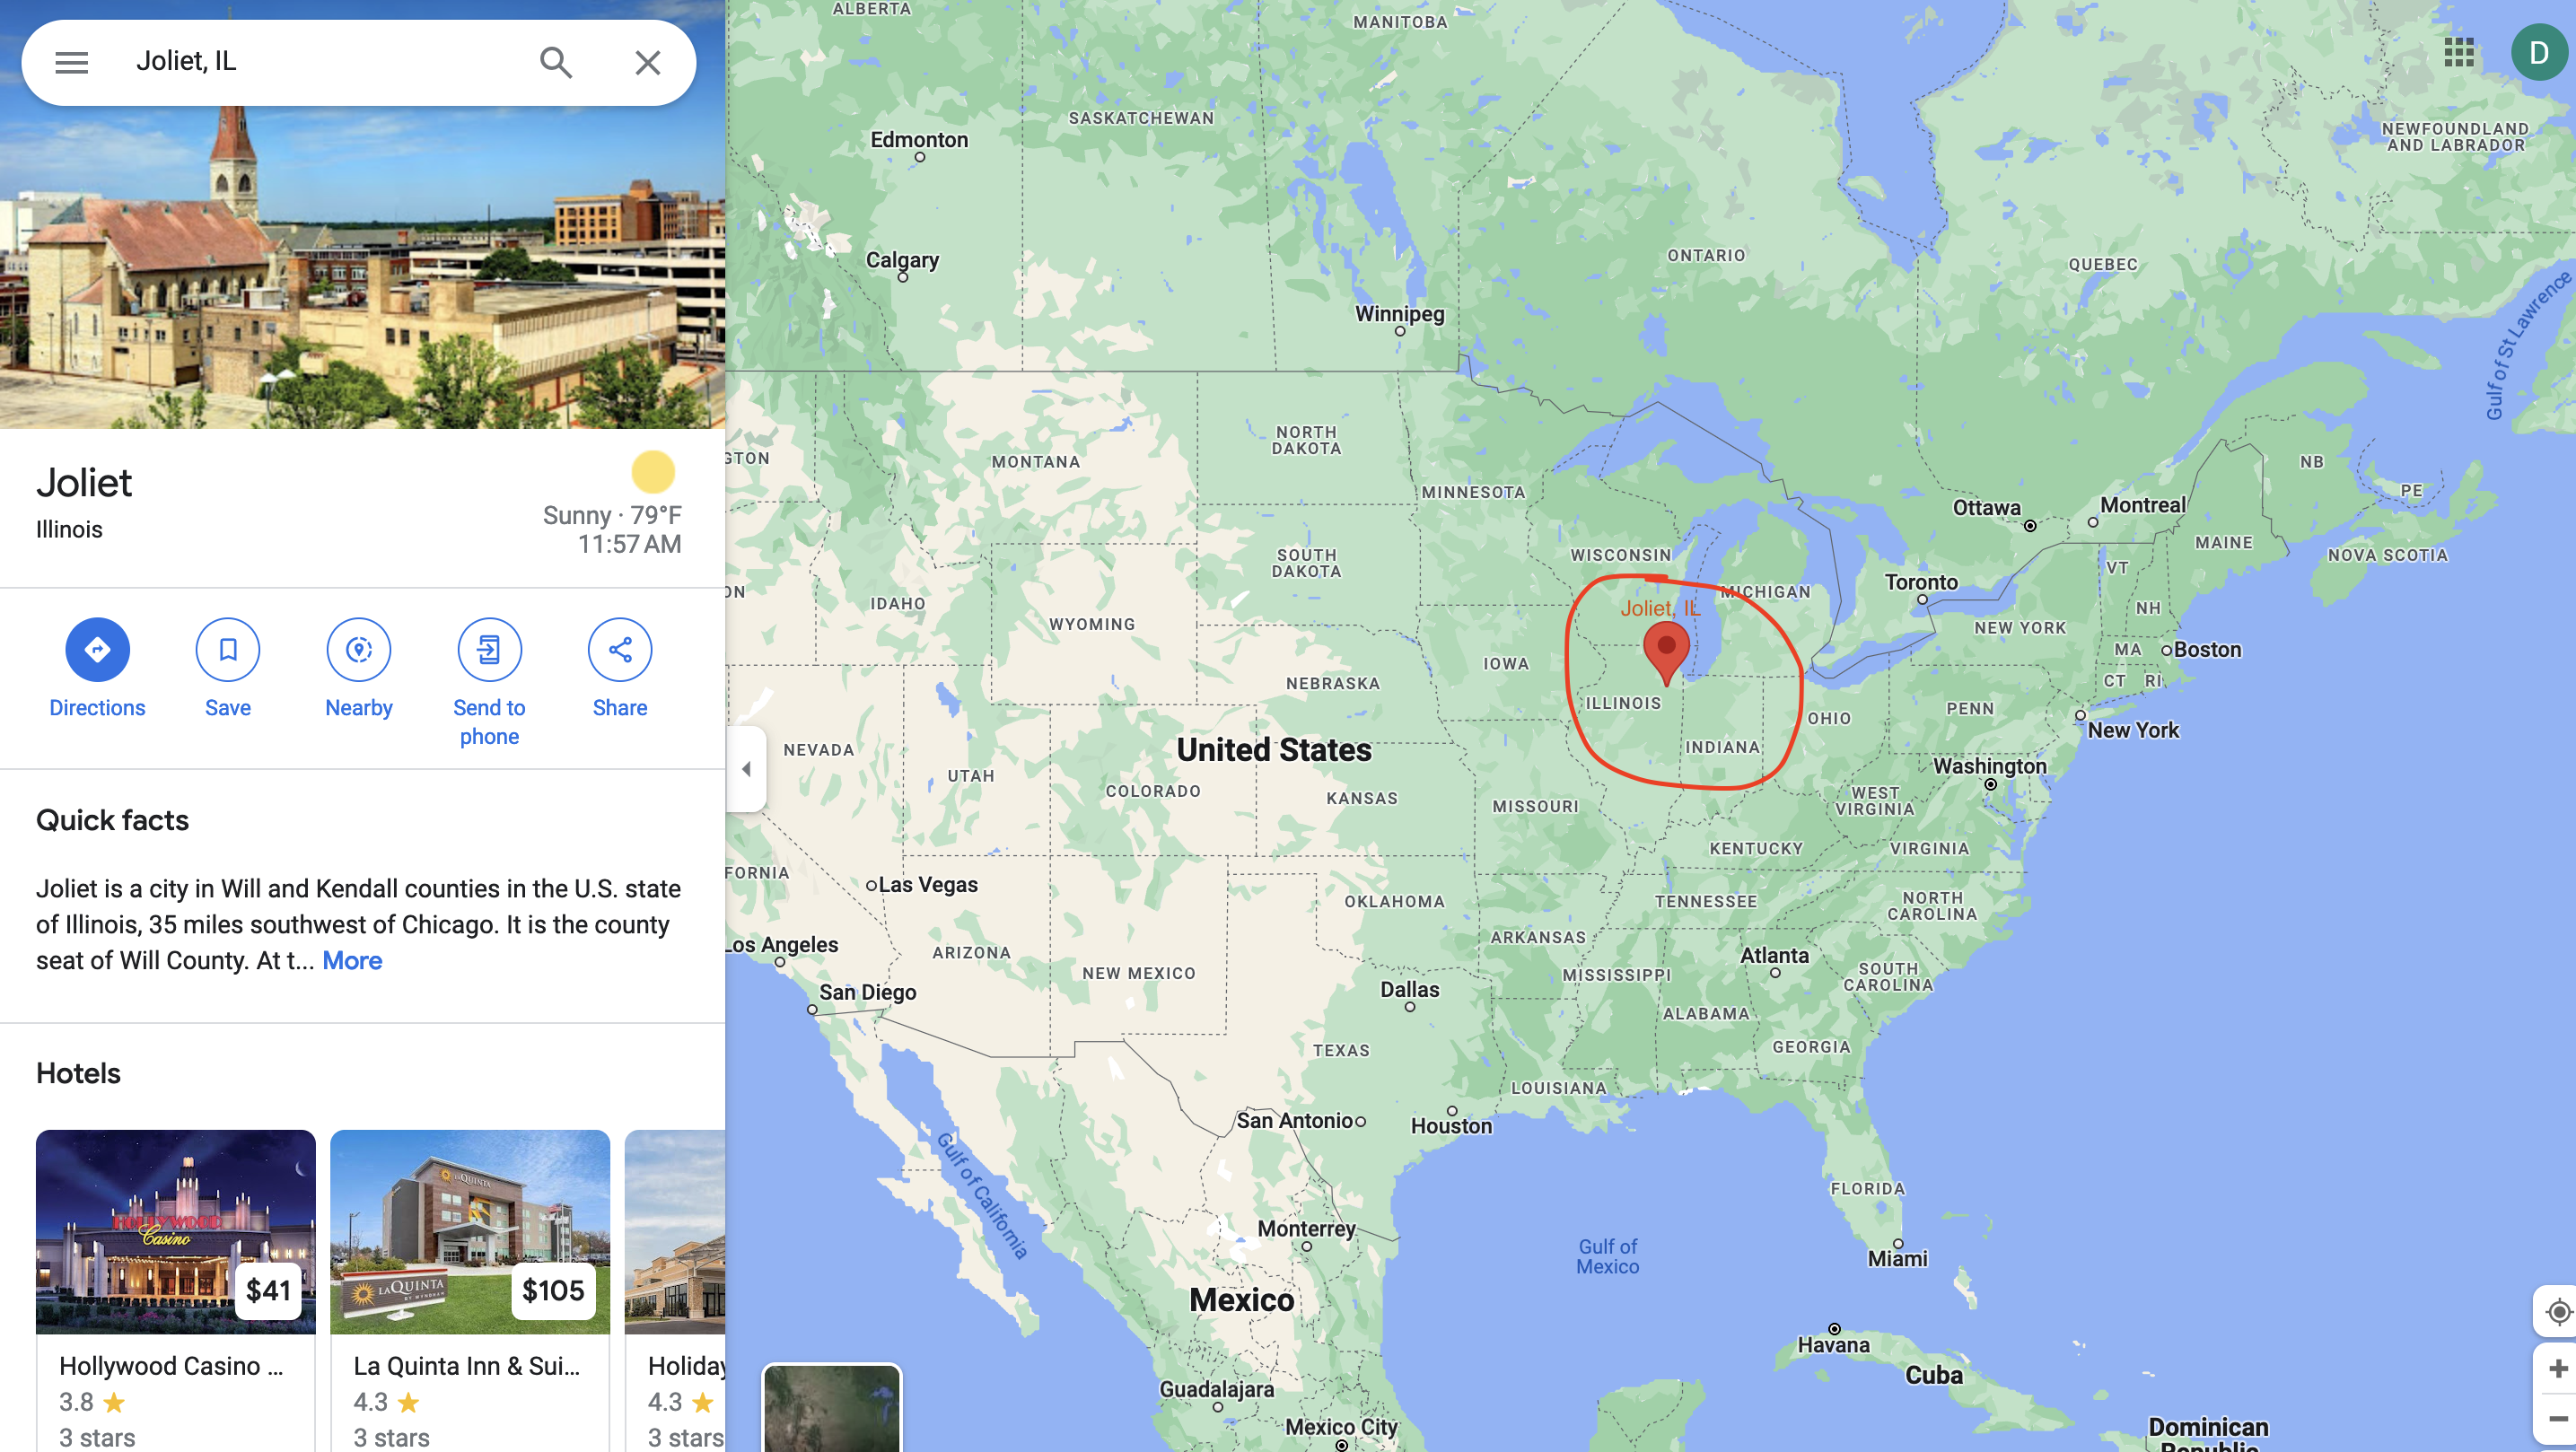  
  
Hmm. Let's consult a jetstream map to get sense of aggregate movements of air on the continent

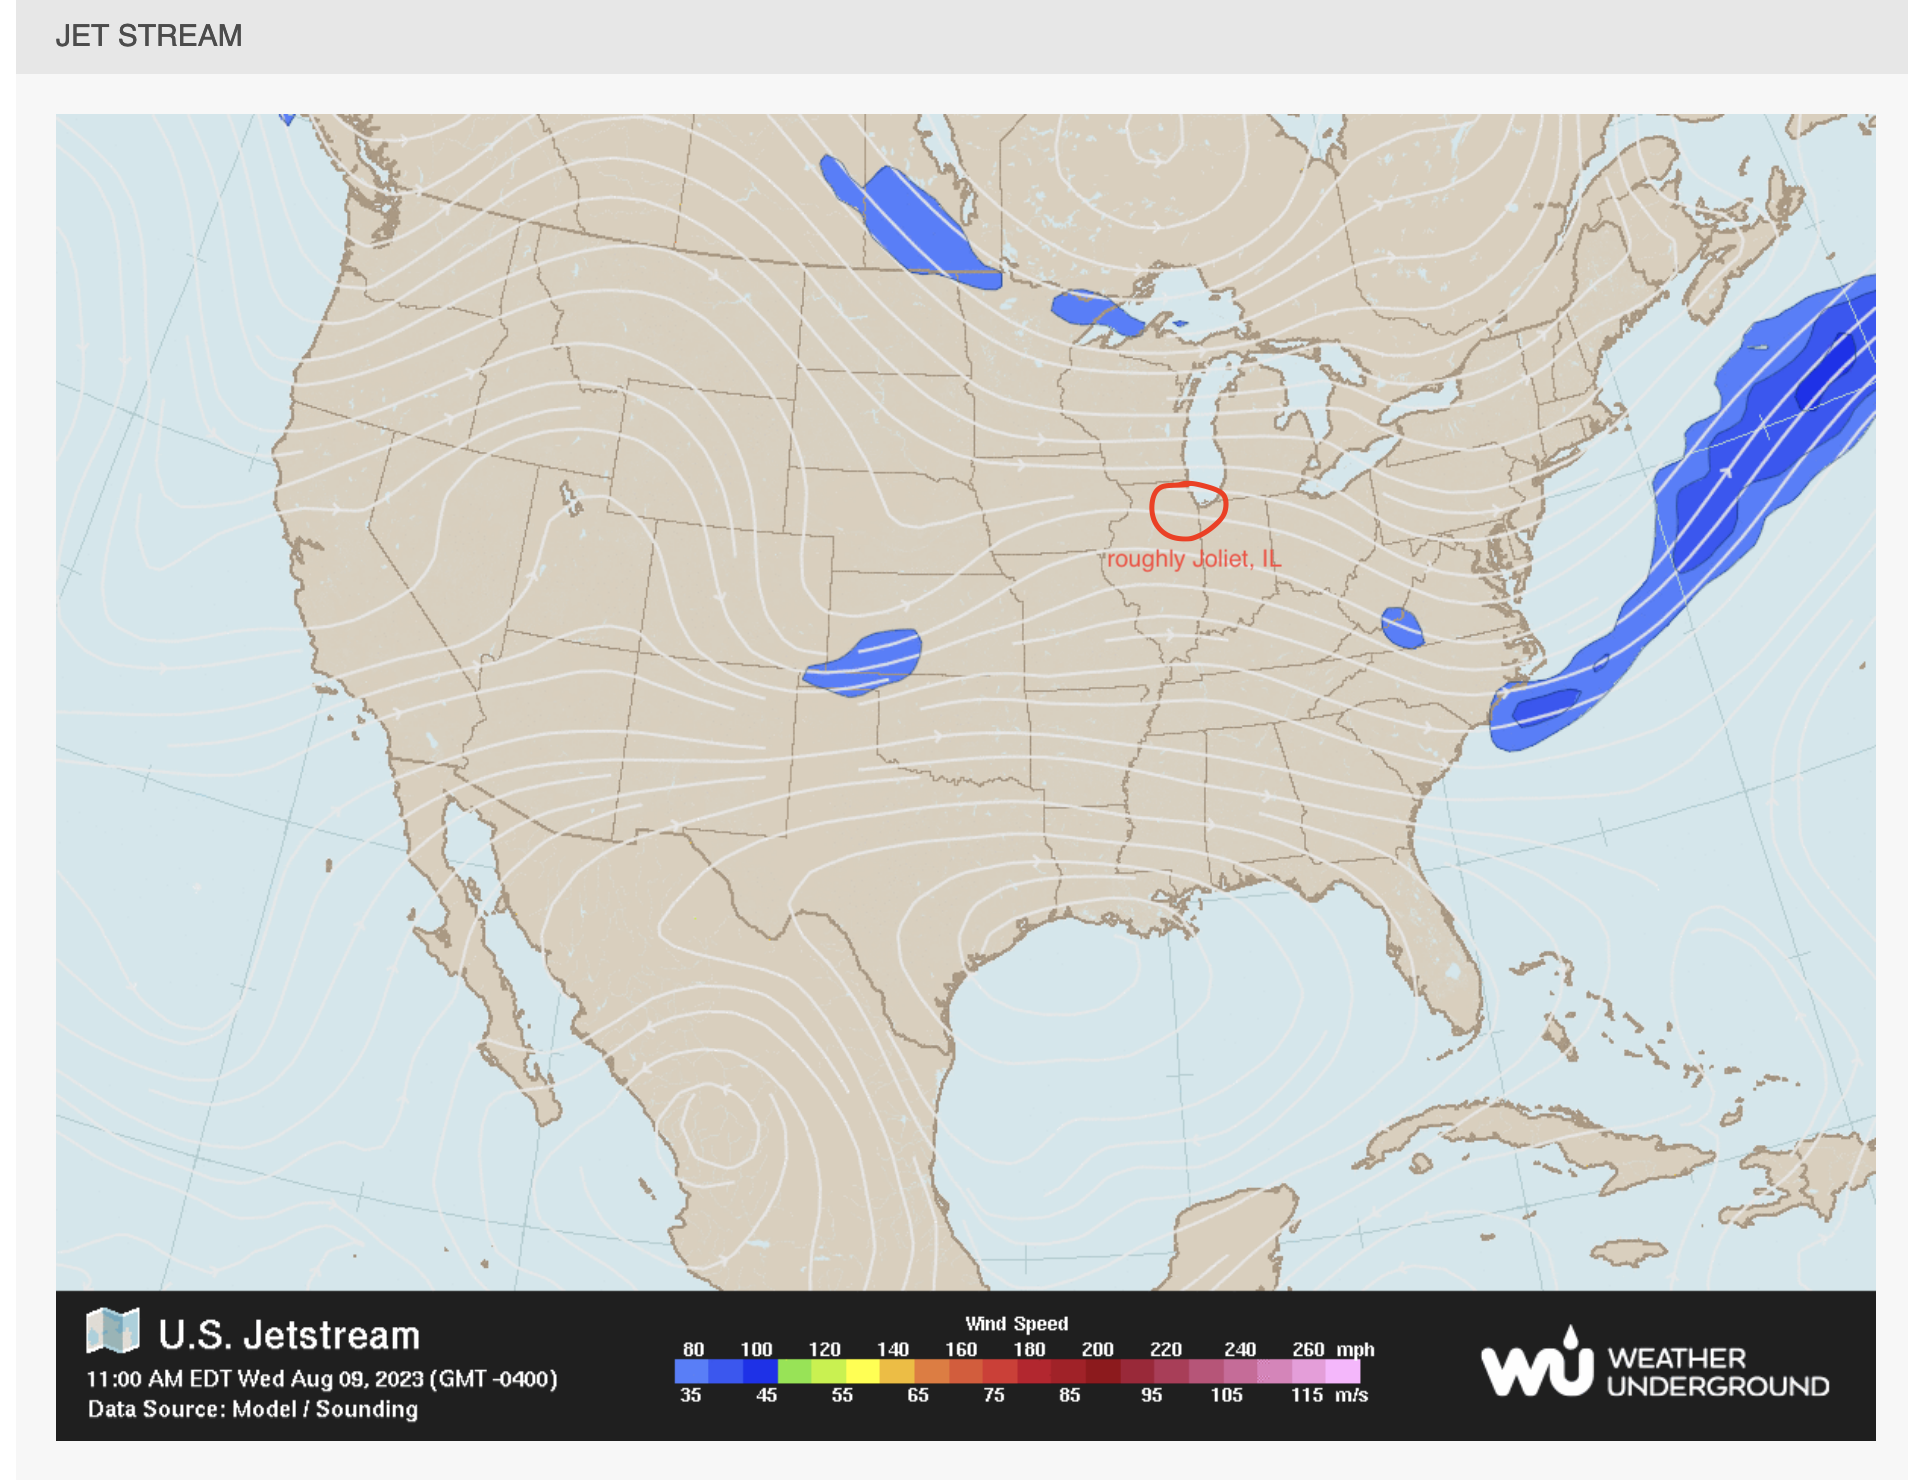
  
  
Obviously jetstreams fluctuate constantly, especially with the growing effect of rising average global temps, but this jetstream map 
certainly illustrates the cooling effect of colder, Canadian air from the North and West

Let's see if the opposite holds true for higher outlier temps

In [15]:
winter_too_high = winter_data[winter_data["Temperature(F)"] >= 60]
winter_too_high["WindDirection"].value_counts()

WindDirection
South    73
West     10
North     4
East      2
Name: count, dtype: int64

There appears to be a strong correlation between winds originating from southern directions and warmer than usual temps in the winter months, which makes sense since the air gets warmer towards the equator. So overall, outlier temps during the winter months can be attributed to the direction of the wind blowing over Joliet, with North/Western winds bringing colder air from Canada and Southern winds bringing warmer air in from the Gulf of Mexico(?)

In [16]:
weather_data_datetime_index.sample()

Month  Temperature(F)  Dewpoint(F)  FeelsLike(F)  Pressure(mb)  PrecipDay(in)  PrecipYr(in)  WindSpeed(mph) WindDirection  RelativeHumidity  Visibility(mi) Conditions  SunRise(HH)  SunSet(HH)
ObservationDateTime                                                                                                                                                                                                       
2022-10-12 16:55:00+00:00     10            64.0           55            64       1005.42           0.01          9.68            11.5         South             0.727            10.0  Scattered            7          18

### One Hot Encoding Categorical Values

Let's explore the correlation of our data without the "Temperature(F)" column. In particular, we want to watch out for multi-colinearity, as this is a regression problem.  

In the interest of time, and although it might be naive, I will create a correlation matrix including the one-hot-encoded values for each categorical variable.
  
We'll use sk learn's column transformer module to simplify the one hot encoding process

In [17]:
# we will use sci-kit-learn's one hot encoder

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

transformed_months = ohe.fit_transform(np.array(weather_data_datetime_index["Month"]).reshape(-1,1))

ohe.categories_[0] = ["Month_Jan","Month_Feb","Month_Mar","Month_Apr","Month_May","Month_Jue","Month_Jul","Month_Aug","Month_Sep","Month_Oct","Month_Nov","Month_Dec"]

# Let's add the one-hot encoded month columns to the end of the dataset.
weather_data_datetime_index[ohe.categories_[0]] = transformed_months.toarray()

weather_data_datetime_index.drop("Month", axis=1, inplace=True)

weather_data_datetime_index.sample()

Temperature(F)  Dewpoint(F)  FeelsLike(F)  Pressure(mb)  PrecipDay(in)  PrecipYr(in)  WindSpeed(mph) WindDirection  RelativeHumidity  Visibility(mi)    Conditions  SunRise(HH)  SunSet(HH)  Month_Jan  Month_Feb  Month_Mar  Month_Apr  Month_May  Month_Jue  Month_Jul  Month_Aug  Month_Sep  Month_Oct  Month_Nov  Month_Dec
ObservationDateTime                                                                                                                                                                                                                                                                                                                                       
2019-12-07 17:55:00+00:00            37.0           28            37       1028.11            0.0         15.44             6.9         South               0.7            10.0  Overcast Sky            7          16        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        1.0

In [18]:
# Let's do the rest of the categorical variables using the column transformer module

categorical_df = weather_data_datetime_index.iloc[:, [7,10]] #8="WindDirection", 11="SunRise(HH)"

In [19]:
categorical_df

WindDirection   Conditions
ObservationDateTime                                 
2018-05-01 10:55:00+00:00         South  Clear Skies
2018-05-01 16:55:00+00:00         South    Scattered
2018-05-01 22:55:00+00:00         South  Clear Skies
2018-05-02 04:55:00+00:00         South  Clear Skies
2018-05-02 10:55:00+00:00         South  Clear Skies
...                                 ...          ...
2023-05-04 04:15:00+00:00          East  Clear Skies
2023-05-04 10:15:00+00:00         North  Clear Skies
2023-05-04 15:35:00+00:00         South  Clear Skies
2023-05-04 21:35:00+00:00         South  Clear Skies
2023-05-05 04:15:00+00:00         South  Clear Skies

[7324 rows x 2 columns]

In [20]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder


one_hot_transformer = make_column_transformer(
    (OneHotEncoder(), ['WindDirection','Conditions']),
    remainder='passthrough')

transformed_cols = one_hot_transformer.fit_transform(categorical_df).toarray()

# transformed_df = pd.DataFrame(transformed_cols, columns=one_hot_transformer.get_feature_names_out())

# transformed_df.columns = [name[15:] for name in transformed_df.columns]
# transformed_df.head()

In [21]:
new_col_names = [name[15:] for name in one_hot_transformer.get_feature_names_out()]

In [22]:
new_col_names

['WindDirection_East',
 'WindDirection_North',
 'WindDirection_South',
 'WindDirection_West',
 'Conditions_Broken Sky',
 'Conditions_Clear Skies',
 'Conditions_Low Visibility',
 'Conditions_Overcast Sky',
 'Conditions_Scattered']

In [23]:
transformed_cols

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [24]:
### Insert these new columns into weather_data_datetime_index

# wind direction
for i in range(4):
    weather_data_datetime_index.insert(7, new_col_names[i], transformed_cols[:,i])

#drop the old "WindDirection" column
weather_data_datetime_index.drop(columns = ["WindDirection"], inplace=True)
weather_data_datetime_index.sample()

Temperature(F)  Dewpoint(F)  FeelsLike(F)  Pressure(mb)  PrecipDay(in)  PrecipYr(in)  WindSpeed(mph)  WindDirection_West  WindDirection_South  WindDirection_North  WindDirection_East  RelativeHumidity  Visibility(mi)   Conditions  SunRise(HH)  SunSet(HH)  Month_Jan  Month_Feb  Month_Mar  Month_Apr  Month_May  Month_Jue  Month_Jul  Month_Aug  Month_Sep  Month_Oct  Month_Nov  Month_Dec
ObservationDateTime                                                                                                                                                                                                                                                                                                                                                                                                          
2022-08-03 04:35:00+00:00            75.0           68            75       1011.86           0.21          7.98             6.9                 0.0                  1.0                  0.0                 0.0             0.784            10.0  Clear Skies            5          20        0.0        0.0        0.0        0.0        0.0        0.0        0.0        1.0        0.0        0.0        0.0        0.0

In [25]:
# Let's do the same for the "Conditions" column.

# # wind direction
for i in range(5):
    weather_data_datetime_index.insert(14, new_col_names[i+4], transformed_cols[:,i+4])

#drop the old "Conditions" column
weather_data_datetime_index.drop(columns = ["Conditions"], inplace=True)
weather_data_datetime_index.sample()

Temperature(F)  Dewpoint(F)  FeelsLike(F)  Pressure(mb)  PrecipDay(in)  PrecipYr(in)  WindSpeed(mph)  WindDirection_West  WindDirection_South  WindDirection_North  WindDirection_East  RelativeHumidity  Visibility(mi)  Conditions_Scattered  Conditions_Overcast Sky  Conditions_Low Visibility  Conditions_Clear Skies  Conditions_Broken Sky  SunRise(HH)  SunSet(HH)  Month_Jan  Month_Feb  Month_Mar  Month_Apr  Month_May  Month_Jue  Month_Jul  Month_Aug  Month_Sep  Month_Oct  Month_Nov  Month_Dec
ObservationDateTime                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
2018-07-14 10:55:00+00:00            73.0           72            73       1018.29            0.0          7.89             0.0                 0.0                  0.0                  1.0                 0.0             0.941             4.0                   1.0                      0.0                        0.0                     0.0                    0.0            5          20        0.0        0.0        0.0        0.0        0.0        0.0        1.0        0.0        0.0        0.0        0.0        0.0

### Correlation

Let's check for colinearity in our features, using pandas and seaborn to visualize the correlation matrix

In [26]:
features_df = weather_data_datetime_index.drop(columns=["Temperature(F)"])

In [27]:
features_df.corr() # the default metric is the Pearson correlation coefficient

Dewpoint(F)  FeelsLike(F)  Pressure(mb)  PrecipDay(in)  PrecipYr(in)  WindSpeed(mph)  WindDirection_West  WindDirection_South  WindDirection_North  WindDirection_East  RelativeHumidity  Visibility(mi)  Conditions_Scattered  Conditions_Overcast Sky  Conditions_Low Visibility  Conditions_Clear Skies  Conditions_Broken Sky  SunRise(HH)  SunSet(HH)  Month_Jan  Month_Feb  Month_Mar  Month_Apr  Month_May  Month_Jue  Month_Jul  Month_Aug  Month_Sep  Month_Oct  Month_Nov  Month_Dec
Dewpoint(F)                   1.000000      0.918087     -0.386301       0.080845      0.352981       -0.132330           -0.200311             0.157039             0.010763            0.012420          0.151153        0.003570              0.163624                -0.153264                   0.052810               -0.035448               0.042917    -0.590140    0.691253  -0.346333  -0.321403  -0.213978  -0.086094   0.127619   0.271615   0.361988   0.338790   0.236140   0.017433  -0.173981  -0.247829
FeelsLike(F)                  0.918087      1.000000     -0.297963       0.098516      0.325711       -0.070899           -0.170131             0.207611            -0.057619            0.012561         -0.223970        0.149204              0.158913                -0.247539                   0.017527                0.074409               0.008060    -0.616699    0.723165  -0.381881  -0.331618  -0.187126  -0.028591   0.146837   0.285587   0.343900   0.318510   0.223596   0.025501  -0.172167  -0.278356
Pressure(mb)                 -0.386301     -0.297963      1.000000      -0.044623     -0.048658       -0.231747           -0.091650            -0.158940             0.166292            0.076251         -0.164450        0.123505             -0.121255                -0.079832                   0.002958                0.225126              -0.103288     0.121706   -0.161228   0.089222   0.070829   0.075880  -0.102926  -0.063609  -0.103888  -0.026388  -0.039776   0.031044  -0.008112   0.088325  -0.003089
PrecipDay(in)                 0.080845      0.098516     -0.044623       1.000000     -0.056242       -0.037388           -0.019566            -0.019222             0.036466           -0.006935         -0.047625        0.022936              0.051914                -0.051081                   0.001289                0.006322              -0.007212    -0.166736    0.181019  -0.053387  -0.040353  -0.044610   0.170191   0.068184   0.001022   0.015110   0.195097  -0.068614  -0.078825  -0.085960  -0.082454
PrecipYr(in)                  0.352981      0.325711     -0.048658      -0.056242      1.000000       -0.110460           -0.023036             0.006441             0.014705           -0.003910          0.059118        0.034169              0.027978                -0.102396                   0.038278                0.051891               0.008508    -0.095639    0.072284  -0.353003  -0.277658  -0.275099  -0.198233  -0.101066   0.022707   0.104759   0.169432   0.238199   0.327306   0.326260  -0.001316
WindSpeed(mph)               -0.132330     -0.070899     -0.231747      -0.037388     -0.110460        1.000000            0.241908             0.247099            -0.492563            0.141278         -0.327885        0.113272              0.061139                 0.138312                  -0.099430               -0.205710               0.095149     0.087132   -0.107558   0.030163   0.084438   0.115258   0.096369   0.024842  -0.055603  -0.098435  -0.120307  -0.073107  -0.043577   0.024566   0.025102
WindDirection_West           -0.200311     -0.170131     -0.091650      -0.019566     -0.023036        0.241908            1.000000            -0.285391            -0.435638           -0.159168         -0.136841        0.064482              0.029390                 0.062393                  -0.040150               -0.083847               0.024990     0.135546   -0.147692   0.069738   0.041516   0.016827   0.041362  -0.062565  -0.066602  -0.042947  -0.056487  -0.056385  -0.005740  

[Text(0.5, 0, 'Dewpoint(F)'),
 Text(1.5, 0, 'FeelsLike(F)'),
 Text(2.5, 0, 'Pressure(mb)'),
 Text(3.5, 0, 'PrecipDay(in)'),
 Text(4.5, 0, 'PrecipYr(in)'),
 Text(5.5, 0, 'WindSpeed(mph)'),
 Text(6.5, 0, 'WindDirection_West'),
 Text(7.5, 0, 'WindDirection_South'),
 Text(8.5, 0, 'WindDirection_North'),
 Text(9.5, 0, 'WindDirection_East'),
 Text(10.5, 0, 'RelativeHumidity'),
 Text(11.5, 0, 'Visibility(mi)'),
 Text(12.5, 0, 'Conditions_Scattered'),
 Text(13.5, 0, 'Conditions_Overcast Sky'),
 Text(14.5, 0, 'Conditions_Low Visibility'),
 Text(15.5, 0, 'Conditions_Clear Skies'),
 Text(16.5, 0, 'Conditions_Broken Sky'),
 Text(17.5, 0, 'SunRise(HH)'),
 Text(18.5, 0, 'SunSet(HH)'),
 Text(19.5, 0, 'Month_Jan'),
 Text(20.5, 0, 'Month_Feb'),
 Text(21.5, 0, 'Month_Mar'),
 Text(22.5, 0, 'Month_Apr'),
 Text(23.5, 0, 'Month_May'),
 Text(24.5, 0, 'Month_Jue'),
 Text(25.5, 0, 'Month_Jul'),
 Text(26.5, 0, 'Month_Aug'),
 Text(27.5, 0, 'Month_Sep'),
 Text(28.5, 0, 'Month_Oct'),
 Text(29.5, 0, 'Month_Nov'),
 

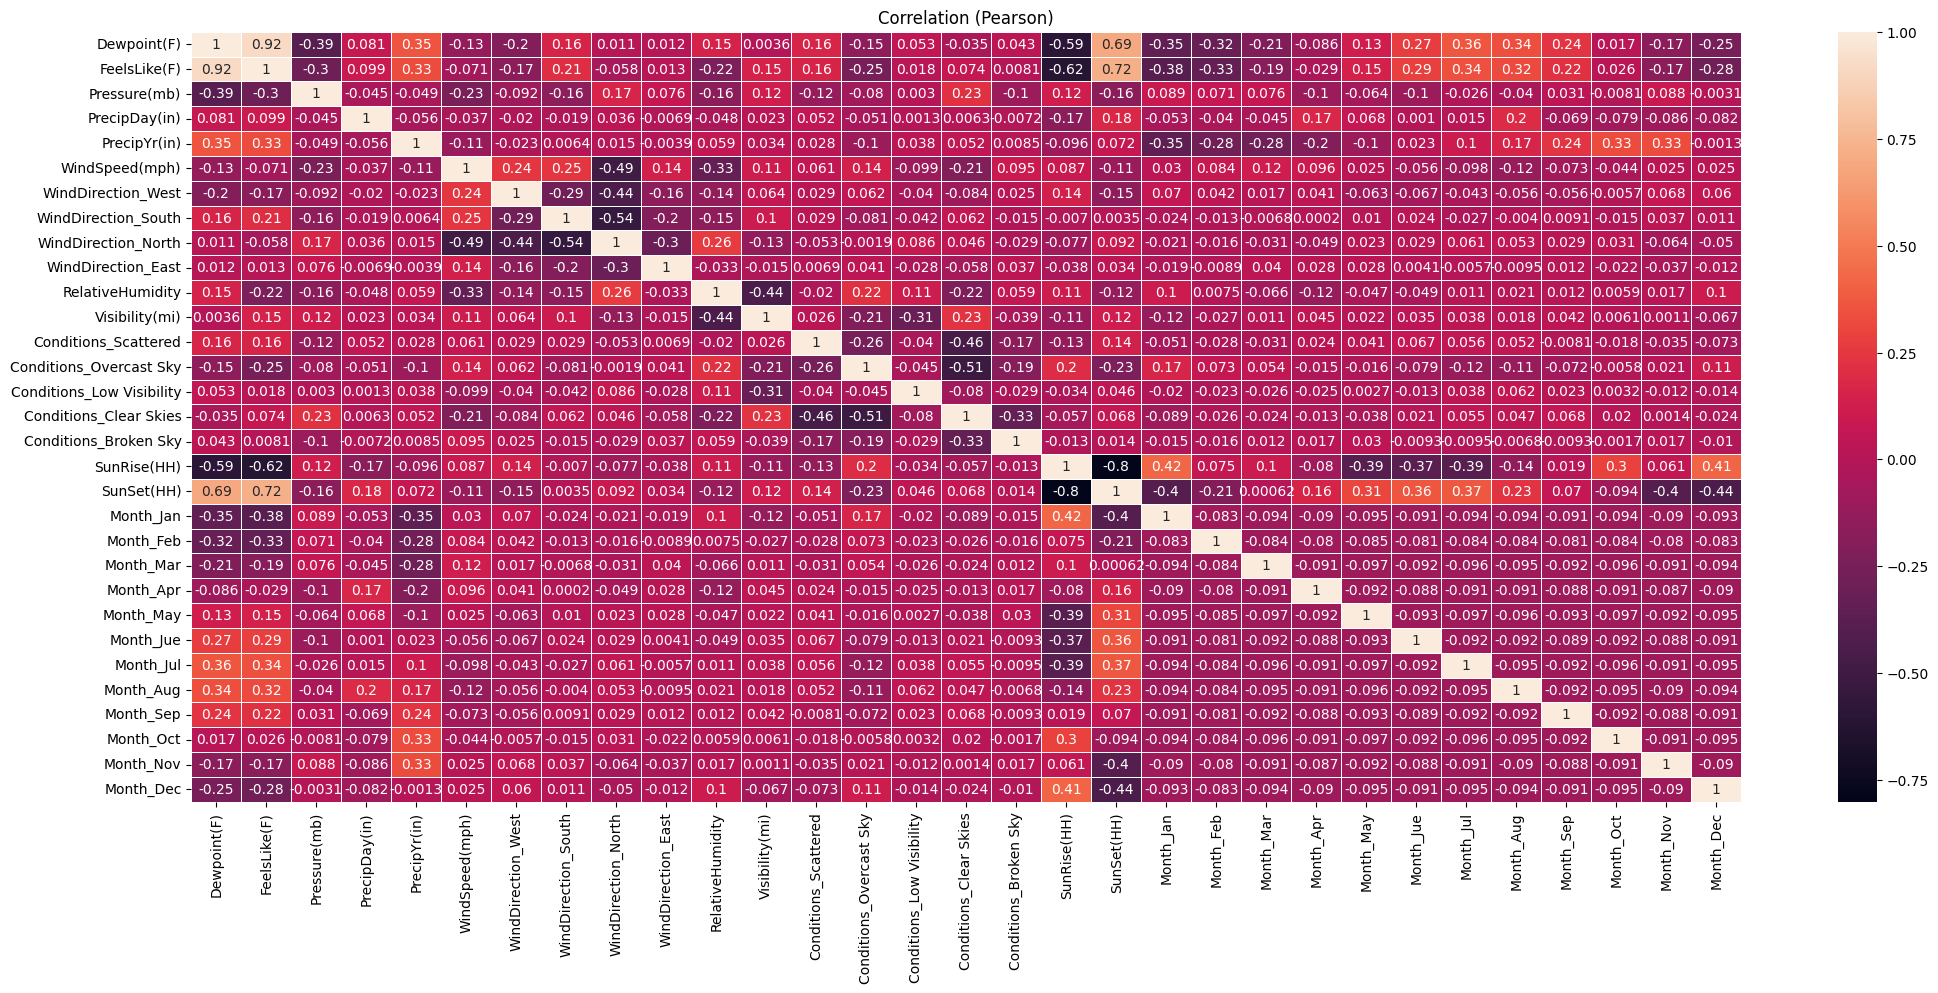

In [28]:
fig, ax = plt.subplots(figsize=(25,10))

ax.title.set_text("Correlation (Pearson)")

corr_matrix = sns.heatmap(features_df.corr(), annot=True, linewidths=.5, ax=ax)

corr_matrix.set_xticklabels(labels = features_df.columns, rotation=90)


Notes based on this correlation matrix:
- sunrise and sunset are highly correlated. Let's drop the "Sunset(HH)" column
- Dewpoint and Feelslike are also highly correlated. Let's drop "FeelsLike"
- Dewpoint and Sunrise as well. Let's drop "Dewpoint", as it's likely highly colinear with the recorded temp as well.
- We can drop the WindDirection_North column because it is fairly negatively colinear with East, West, and South.
- SunRise(HH) is likely colinear with the Months of the year. Let's drop this column too
- ClearSkies is neagatively colinear with Scattered and Overcast skies. Let's drop "Conditions_Clearskies"
- The low observability condition is 

In [29]:
features_df.drop(columns=["SunSet(HH)","FeelsLike(F)", "Dewpoint(F)", "WindDirection_North", "SunRise(HH)","Conditions_Clear Skies"], axis=1, inplace=True)

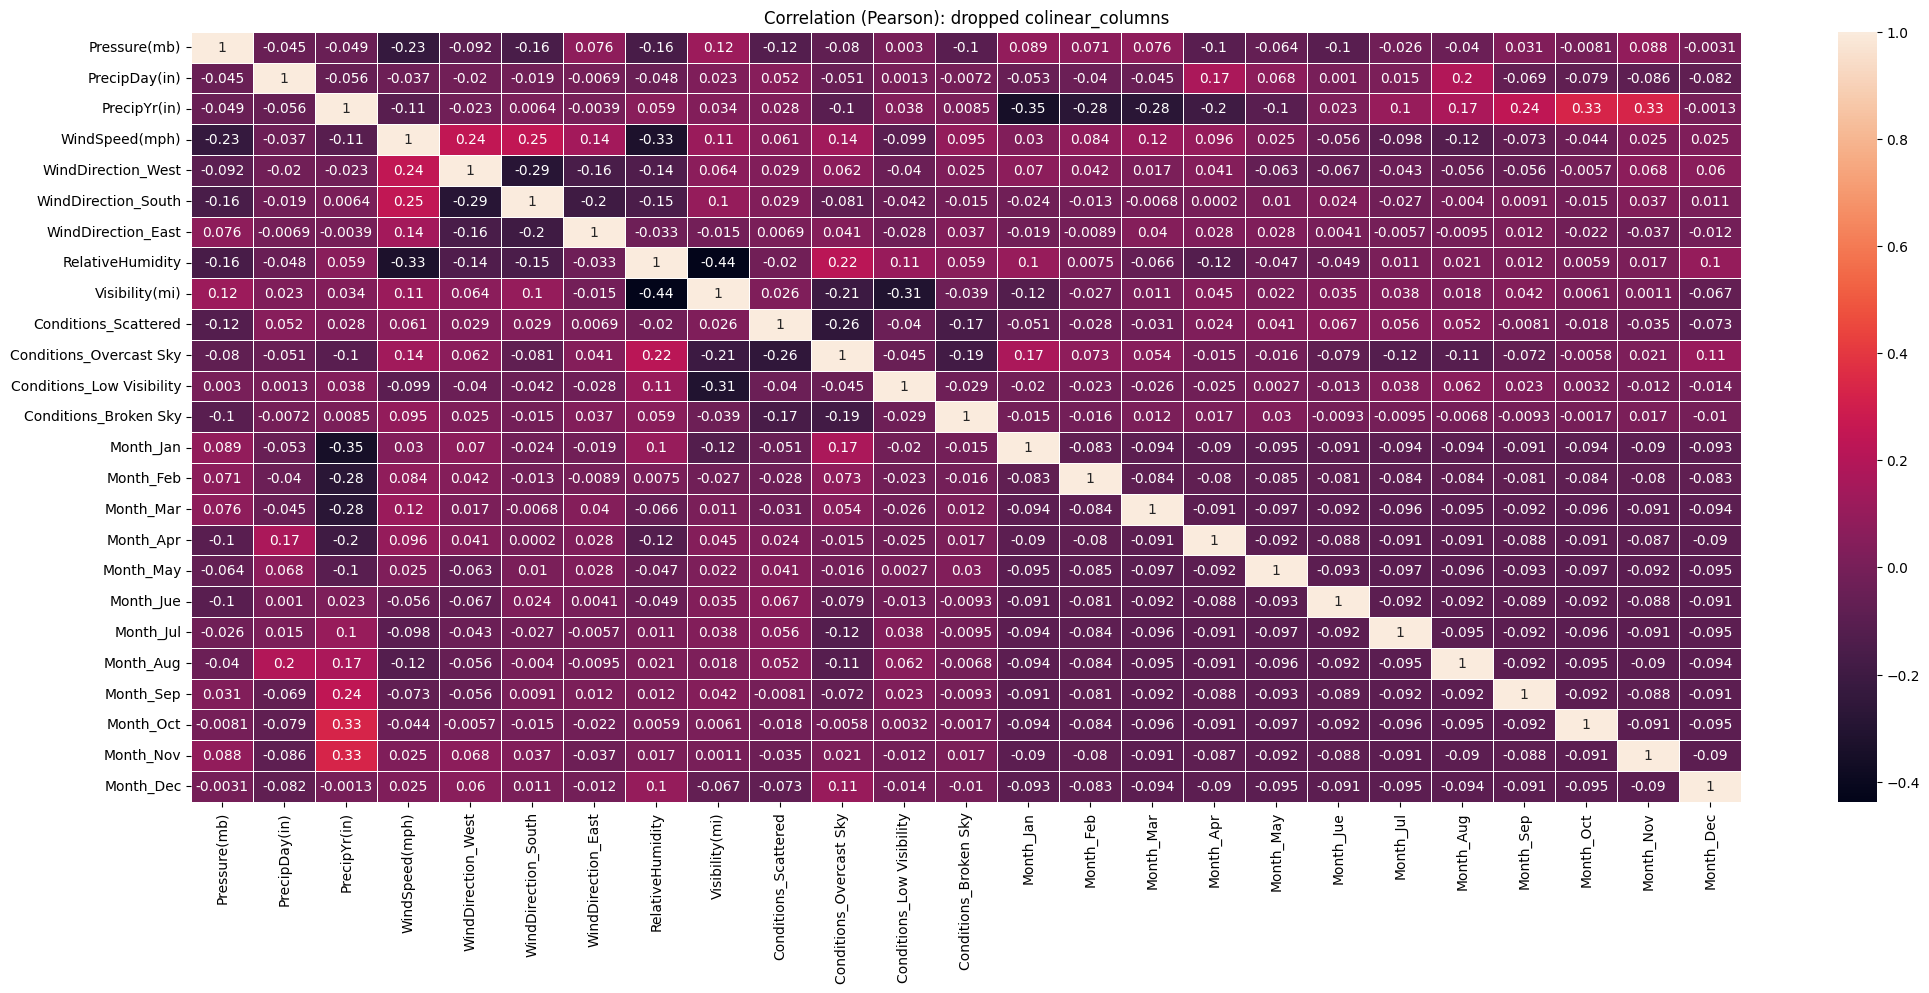

In [30]:
fig, ax = plt.subplots(figsize=(25,10))

ax.title.set_text("Correlation (Pearson): dropped colinear_columns")

corr_matrix = sns.heatmap(features_df.corr(), annot=True, linewidths=.5, ax=ax)



I am comfortable with this reduced feature set, as none of our Pearson r-values exceed +- .45

Since I'm planning on using a Random Forest regressor to predict the temperatures, I won't address the outliers, since given enough randomness the outliers should be statistically irrelevant

In [31]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7324 entries, 2018-05-01 10:55:00+00:00 to 2023-05-05 04:15:00+00:00
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Pressure(mb)               7309 non-null   float64
 1   PrecipDay(in)              7324 non-null   float64
 2   PrecipYr(in)               7324 non-null   float64
 3   WindSpeed(mph)             7324 non-null   float64
 4   WindDirection_West         7324 non-null   float64
 5   WindDirection_South        7324 non-null   float64
 6   WindDirection_East         7324 non-null   float64
 7   RelativeHumidity           7324 non-null   float64
 8   Visibility(mi)             7324 non-null   float64
 9   Conditions_Scattered       7324 non-null   float64
 10  Conditions_Overcast Sky    7324 non-null   float64
 11  Conditions_Low Visibility  7324 non-null   float64
 12  Conditions_Broken Sky      7324 non-null   float64
 13  

In [32]:
temps = weather_data_datetime_index["Temperature(F)"].values.tolist()

In [33]:
features_df.insert(0, "Temperature(F)", temps)

In [35]:
features_df.head()

Temperature(F)  Pressure(mb)  PrecipDay(in)  PrecipYr(in)  WindSpeed(mph)  WindDirection_West  WindDirection_South  WindDirection_East  RelativeHumidity  Visibility(mi)  Conditions_Scattered  Conditions_Overcast Sky  Conditions_Low Visibility  Conditions_Broken Sky  Month_Jan  Month_Feb  Month_Mar  Month_Apr  Month_May  Month_Jue  Month_Jul  Month_Aug  Month_Sep  Month_Oct  Month_Nov  Month_Dec
ObservationDateTime                                                                                                                                                                                                                                                                                                                                                                                                                     
2018-05-01 10:55:00+00:00            55.0       1015.92            0.0          4.44             4.6                 0.0                  1.0                 0.0             0.509            10.0                   0.0                      0.0                        0.0                    0.0        0.0        0.0        0.0        0.0        1.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0
2018-05-01 16:55:00+00:00            81.0       1015.58            0.0          4.44            15.0                 0.0                  1.0                 0.0             0.368            10.0                   1.0                      0.0                        0.0                    0.0        0.0        0.0        0.0        0.0        1.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0
2018-05-01 22:55:00+00:00            82.0       1012.87            0.0          4.44            13.8                 0.0                  1.0                 0.0             0.303            10.0                   0.0                      0.0                        0.0                    0.0        0.0        0.0        0.0        0.0        1.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0
2018-05-02 04:55:00+00:00            73.0       1013.89            0.0          4.44            15.0                 0.0                  1.0                 0.0             0.468            10.0                   0.0                      0.0                        0.0                    0.0        0.0        0.0        0.0        0.0        1.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0
2018-05-02 10:55:00+00:00            70.0       1012.87            0.0          4.44             9.2                 0.0                  1.0                 0.0             0.530            10.0                   0.0                      0.0                        0.0                    0.0        0.0        0.0        0.0        0.0        1.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0

In [36]:
features_df.to_csv("model_data.csv")